# Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

    В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
    Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
    Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.
     

### Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

    shared/problem1-reg_data.csv – данные о времени регистрации

reg_ts	uid
906166566	2
906344325	3
906686169	4
906893386	5
906980227	6

    shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

auth_ts	uid
906166566	2
924422172	2
937374732	2
947425117	2
955630339	2

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [35]:
OUTDATED_RAISE_EXCEPTION=1
OUTDATED_IGNORE=1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors as mcolors
import seaborn as sns
from operator import attrgetter
import pingouin as pg
from scipy import stats

In [36]:
# Считаем файлы, выведем первую строку
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-mileshin/shared/problem1-reg_data.csv')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-mileshin/shared/problem1-auth_data.csv') 
reg_data.head(1)

,reg_ts;uid
0,911382223;1


In [37]:
auth_data.head(1)

,auth_ts;uid
0,911382223;1


Разделитель в датасетах - точка с запятой, даты представлены в формате Unix Timestamp. Добавим исправляющий код в функцию.

In [38]:
# Проверка reg_data на пропущенные значения
reg_data.isna().sum()
# Пропущенных значений нет

reg_ts;uid    0
dtype: int64

In [39]:
# Проверка auth_data на пропущенные значения
auth_data.isna().sum()
# Пропущенных значений нет

auth_ts;uid    0
dtype: int64

In [40]:
# Проверим диапазон дат в auth_data, переведя их в pandas datetime
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-mileshin/shared/problem1-auth_data.csv', sep = ';') 
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'],unit='s')
print(f'Минимальная дата - {auth_data["auth_ts"].min()}, максимальная дата - {auth_data["auth_ts"].max()}.')

Минимальная дата - 1998-11-18 09:43:43, максимальная дата - 2020-09-23 15:17:24.


In [41]:
# Напишем функцию для расчета Retention rate в заданный период

def period_retention_matrix(reg_data_file, auth_data_file, period_start, period_end):
    
    # Считываем файлы, указываем разделитель
    reg_data = pd.read_csv(reg_data_file, sep = ';')
    auth_data = pd.read_csv(auth_data_file, sep = ';')
    
    # Преобразуем Unix Timestamp в pandas Datetype и сокращаем до дня
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'],unit='s').dt.to_period('D')
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'],unit='s').dt.to_period('D')
    
    # Объединяем датасеты по uid, используем right merge, чтобы сохранить все даты авторизаций
    full_data = reg_data.merge(auth_data, how = 'right', on = 'uid')
    
    # Добавляем колонку с номером дня возврата пользователя, преобразуем тип в integer
    full_data['return_day'] = (full_data['auth_ts'] - full_data['reg_ts']).apply(lambda x: x.n)
    
    # Преобразуем даты начала и конца задаваемого периода, чтобы по ним можно было фильтровать итоговый датасет
    period_start = pd.to_datetime(period_start).to_period('D') 
    period_end = pd.to_datetime(period_end).to_period('D') 
    
    # Формируем итоговый датасет, отфильтрованный по указанным датам
    period_data = full_data.query('reg_ts >= @period_start & auth_ts <= @period_end')
    
    # Создаем pivot-таблицу для подсчета когорт. Индексы - дни когорты, колонки - дни возвращения, 
    # данные - агрегированные количества уникальных пользователей в когорте.
    period_pivot = period_data.pivot_table(index='reg_ts', columns='return_day', values='uid', aggfunc='nunique')
    
    # Создаем переменную для количества пользователей в нулевых когортах 
    cohort_0 = period_pivot.iloc[:, 0]
    
    # Создаем финальный датасет с рассчитанными значениями Retention rate по дням возвращения
    period_retention_matrix = period_pivot.divide(cohort_0, axis=0)
    
    # Строим тепловую карту с Retention rate (коэффициентами удержания)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    sns.heatmap(period_retention_matrix,
                mask=period_retention_matrix.isnull(),
                annot=True,
                fmt='.1%',
                cmap='Spectral',
                ax=ax[1])
    ax[1].set_title('Коэффициенты удержания пользователей по дням', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

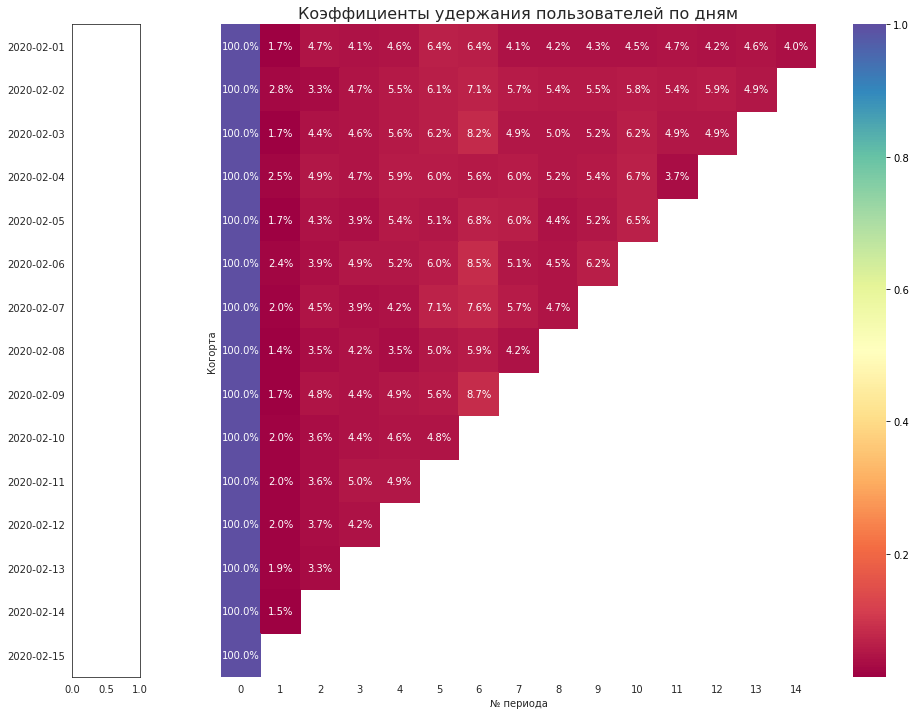

In [42]:
# Проверка работы функции
reg_data_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-mileshin/shared/problem1-reg_data.csv'
auth_data_file = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-mileshin/shared/problem1-auth_data.csv'

period_retention_matrix(reg_data_file, auth_data_file, '2020-02-01', '2020-02-15')

### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Формат данных: user_id revenue testgroup 1 0 b 2 0 a 3 0 a 4 0 b 5 0 b

<div class="alert alert-block alert-info">

#### Предлагается проверить метрики: Revenue, ARPU, ARPPU и Конверсия в платящих пользователей. Сначала итоговые показатели, потом вероятность получить статзначимую разницу в результатах.
1. Гипотеза 0: Акционные предложения не влияют на изменения метрик в группах.
2. Гипотеза 1: Акционные предложения влияют на изменения метрик в группах.

In [43]:
# Загружаем датасет, проверяем разделители, приводим к читабельному виду
ab_data = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')
ab_data.head()
# С датасетом ab_data можно работать дальше

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [44]:
# Проверяем типы данных 
ab_data.info()
# Они пригодны для исследования

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [45]:
# Проверяем пропуски в данных
ab_data.isna().sum()
# Пропусков нет, можно анализировать

user_id      0
revenue      0
testgroup    0
dtype: int64

In [46]:
# Сравним абсолютные результаты revenue, arpu, arppu и конверсии в платящих пользователей

ab_data_copy = ab_data.copy() # делаем копию, чтобы не менять исходный датасет
ab_data_copy['pu'] = ab_data_copy['revenue'] > 0 # добавляем колонку с True/False для определения платящих пользователей

# Группируем по группам a и b, подсчитываем revenue, всех пользователей (auc), платящих пользователей (puc)

agg_ab_data = ab_data_copy.groupby('testgroup').agg( 
revenue = ('revenue', 'sum'),
auc = ('user_id', 'count'),
puc = ('pu', 'sum')
).reset_index()

agg_ab_data['arpu'] = round(agg_ab_data['revenue'] / agg_ab_data['auc'], 2) # расчет arpu
agg_ab_data['arppu'] = round(agg_ab_data['revenue'] / agg_ab_data['puc'], 2) # расчет arppu
agg_ab_data['conversion'] = (agg_ab_data['puc'] / agg_ab_data['auc']) * 100 # расчет conversion

agg_ab_data

,testgroup,revenue,auc,puc,arpu,arppu,conversion
0,a,5136189,202103,1928,25.41,2664.00,0.953969
1,b,5421603,202667,1805,26.75,3003.66,0.890624


In [47]:
# Рассчитаем разницу между показателями и сделаем предварительные выводы
diff_df = agg_ab_data[['revenue', 'arpu', 'arppu', 'conversion']].diff()
diff_df['testgroup'] = agg_ab_data['testgroup']
diff_df


,revenue,arpu,arppu,conversion,testgroup
0,NaN,NaN,NaN,NaN,a
1,285414.0,1.34,339.66,-0.063345,b


<div class="alert alert-block alert-info">
Предварительный вывод: группа b показывает положительную динамику во всех показателях, кроме конверсии. С натяжкой можно заключить, что набор акционных предложений для группы b работает лучше.<br><br>
Однако, для подтверждения этого вывода, необходимо провести статистические тесты.

In [48]:
# Проверим revenue групп на нормальность распределения (pg.normality) и равенство дисперсий (stats.levene)
group_a = ab_data.query("testgroup == 'a'")['revenue']
group_b = ab_data.query("testgroup == 'b'")['revenue']

pg.normality(group_a, method='normaltest')

,W,pval,normal
revenue,585152.731273,0.0,False


In [49]:
pg.normality(group_b, method='normaltest')

,W,pval,normal
revenue,326622.395409,0.0,False


In [50]:
stat, p_value = stats.levene(group_a, group_b)
print(stat, p_value)

# Распределение revenue ненормальное (False для обеих групп), но дисперсии равны (p_value > 0.05)

0.3896289474701388 0.5324948591043842


In [51]:
# Учитывая размер выборок (более 200 тыс участников в каждой группе), можно пренебречь ненормальностью распределения
# и провести t-test с критерием Уэлча для выявления статзначимости различий в ARPU

stats.ttest_ind(group_a, group_b, equal_var = False)

# Не отвергаем нулевую гипотезу, поскольку p-value > 0.05. Не найдены статистически значимые отличия.

Ttest_indResult(statistic=-0.6234876562792212, pvalue=0.5329647014130866)

In [52]:
# Проводим такой же тест для ARPPU (только для платящих пользователей)
# Размер выборок меньше, но все еще достаточно большой (более 1800 участников в каждой группе)

group_a_pu = ab_data.query("testgroup == 'a' and revenue > 0")['revenue']
group_b_pu = ab_data.query("testgroup == 'b' and revenue > 0")['revenue']

stats.ttest_ind(group_a_pu, group_b_pu, equal_var = False)

# Не отвергаем нулевую гипотезу, поскольку p-value > 0.05. Не найдены статистически значимые отличия.

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

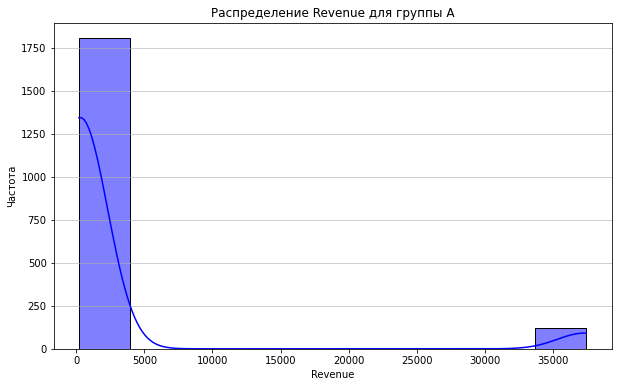

In [53]:
# Визуализируем распределение revenue для каждой группы
plt.figure(figsize=(10, 6))

# Построение гистограммы для группы а
sns.histplot(group_a_pu, bins=10, kde=True, color='blue', alpha=0.5)
plt.title('Распределение Revenue для группы A')
plt.xlabel('Revenue')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

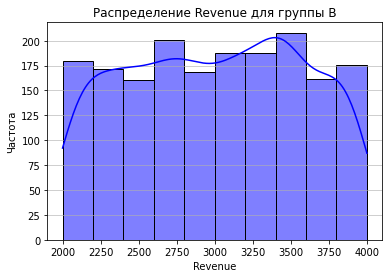

In [54]:
# Построение гистограммы для группы b
sns.histplot(group_b_pu, bins=10, kde=True, color='blue', alpha=0.5)
plt.title('Распределение Revenue для группы B')
plt.xlabel('Revenue')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [55]:
# Проводим z-test для пропорций (конверсии всех пользователей в платящих), так как chi2-test слишком консервативен
# и может привести к ошибке второго рода
# Нам известны данные о количестве платящих пользователей в обеих группах (pu) и общая численность групп (au).

from statsmodels.stats.proportion import proportions_ztest

pu = np.array([1928, 1805])
au = np.array([202103, 202667])
stat, pval = proportions_ztest(pu, au)
if pval < 0.05:
    print(f'Статистика равна {stat}. Полученное p-value {pval} меньше 0.05. Нулевая гипотеза отклоняется.')
else:
    print(f'Статистика равна {stat}. Полученное p-value {pval} больше 0.05. Нулевая гипотеза принимается.')

Статистика равна 2.108028495889841. Полученное p-value 0.035028524642854865 меньше 0.05. Нулевая гипотеза отклоняется.


<div class="alert alert-block alert-info">
    
#### Выводы по Заданию 2<br>
Для полноценного анализа существуют существенные ограничения:<br>
- Мы не знаем причину выбросов в группе A, отсутствует описание клиентов, самих игр, условий акций... У нас есть только revenue.<br>
- Мы не знаем в течение какого времени собирались данные.<br>
- Эксперимент могли закончить раньше срока, получив в какой-то момент p-value для конверсий ниже референсного значения.<br><br>

На основании проведенного анализа и статтестов можно заключить:
Значения денежных метрик в группе B выросли, сгладились выбросы Revenue, но конверсия в платящего пользователя упала. Изменения ARPU и ARPPU не показали статистически значимых результатов, можно сказать, что условия акций для обеих групп имеют одинаковое влияние. При этом, сравнение конверсий (пропорций) в z-test показало статистически значимую разницу, но, поскольку конверсия в платящего пользователя в группе B незначительно упала, можно с осторожностью предположить, что условия для группы B немного хуже, чем для группы А. В целом ситуация крайне противоречивая из-за результатов тестов и однозначные выводы делать рано.<br>

Рекомендации: провести дополнительные статтесты до получения однозначных и устойчивых p-value во всех тестах.

### Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

<div class="alert alert-block alert-info">

#### Для оценки динамики и тренда метрик по результатам проведения события (акции) предлагается рассмотреть следующее: <br><br>
1. MAU/WAU/DAU (в зависимости от точного периода акции) - покажут эффективность применения акции<br>
2. Новые пользователи - покажут привлекательность упоминания акций в приложении/сторонних рекламах/SM и эффективность "сарафанного радио" среди игроков<br>
3. Конверсия игрока без акций в игрока с акциями - покажет привлекательность акции для текущих пользователей<br>
4. ARPU (если акция платная) - покажет ценность "артефактов" и "призов", за ненужное деньги не платят (сомнительная метрика, не уверен. Обычно артефакты просто монетизируются, заплатил - получил)<br>
5. Retetntion rate (коэффициент удержания) - покажет привлекательность акций для "старых" игроков<br>
6. Среднее количество пройденных уровней за сесссию - покажет выполнимость задания. Если будет негативный тренд, значит или заданий много или времени мало<br>
7. Среднее время прохождения всех уровней в сессии - похоже на предыдущую метрику. Можно регулировать количество заданий за период, чтобы пользователи успевали проходить все уровни и не чувствовали разочарование<br>
8. Среднеее время игровой сессии - увеличится, если акция проходит в рамках основной игры<br>
9. Количество сессий - увеличится, если акция проходит вне рамок основной игры<br>
10. Среднее общее игровое время - увеличится и при акции в рамках основной игры и при акции вне рамок основной игры <br><br> 
    
#### С учетом отката на несколько уровней назад в упомянутые метрики добавится: <br><br>
1. Churn rate или просто количество отписок после завершения акции - покажет разочарование игрока, так как игрок может уйти из приложения из-за снижения своего рейтинга.